In [1]:
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

In [2]:
sys.path.append('../python/')

from plotMethods import *
from UNetMethods import *
from constants import *

In [3]:
sys.path.append('../pytorch-3dunet/')

from pytorch3dunet.predict import main

In [4]:
modelPath = '/Users/noah-everett/Documents_non-iCloud/TrainOutput_v2/checkpoints/best_checkpoint.pytorch'

data_numbers = np.arange(220)
data_dir = '/Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdataNumbers/'
data_paths = [data_dir + i + '.h5' for i in data_numbers.astype(str)]

outputDir = '/Users/noah-everett/Documents_non-iCloud/modelOut_v2/'

tmpDir = '/Users/noah-everett/Documents_non-iCloud/DSPS/tmp'

In [5]:
config = get_config_predict(data_paths, modelPath, outputDir)
save_config(config, tmpDir+'/config.yml')

In [6]:
# main(['--config', tmpDir+'/config.yml'])

In [5]:
fileNumber = 217 #56 #45 #30

file = f'/Users/noah-everett/Documents_non-iCloud/modelOut_v2/{fileNumber}_predictions.h5'
f = h5py.File(file, 'r')
pred = f['predictions'][:]
f.close()
pred = pred[0,:,:,:]

file = f'/Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdataNumbers/{fileNumber}.h5'
f = h5py.File(file, 'r')
true = f['y'][:]
f.close()
true = true[:,:,:]

N = 40
step = (pred.shape[0]//N, pred.shape[1]//N, pred.shape[2]//N)
assert (pred.shape[0] % N == 0) and (pred.shape[1] % N == 0) and (pred.shape[2] % N == 0)
pred = pred.reshape(N, step[0], N, step[1], N, step[2]).mean(axis=(1,3,5))
true = true.reshape(N, step[0], N, step[1], N, step[2]).mean(axis=(1,3,5))

np.min(pred): 0.0
np.max(pred): 0.99998534
np.percentile(pred, 90): 0.0
np.percentile(pred, 100): 0.9999853372573853


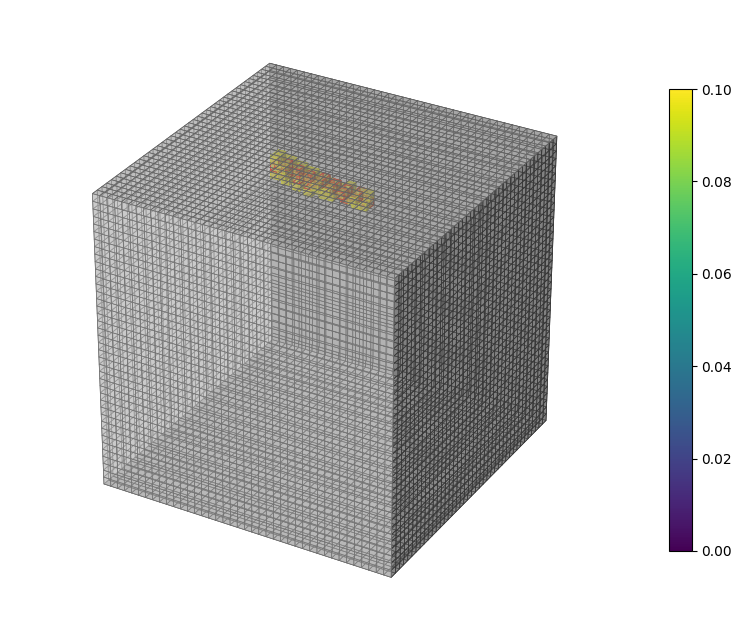

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

gridSize = pred.shape

xEdges = np.linspace(-DETECTOR_SIZE_MM[0]/2, DETECTOR_SIZE_MM[0]/2, gridSize[0] + 1)
yEdges = np.linspace(-DETECTOR_SIZE_MM[1]/2, DETECTOR_SIZE_MM[1]/2, gridSize[1] + 1)
zEdges = np.linspace(-DETECTOR_SIZE_MM[2]/2, DETECTOR_SIZE_MM[2]/2, gridSize[2] + 1)
yEdges, xEdges, zEdges = np.meshgrid(xEdges, yEdges, zEdges)

print('np.min(pred):', np.min(pred))
print('np.max(pred):', np.max(pred))
print('np.percentile(pred, 90):', np.percentile(pred, 90))
print('np.percentile(pred, 100):', np.percentile(pred, 100))

# minVal = np.percentile(pred, 99.5)
# maxVal = np.percentile(pred, 100)
alpha_filled = 0.5
globalColorNorm = cm.colors.Normalize(vmin=minVal, vmax=maxVal)
pred = np.where(pred < minVal, 0, pred)
colors = cm.viridis(globalColorNorm(pred))

ax = plot_grid(
    ax,
    xEdges,
    yEdges,
    zEdges,
    recoGrid=pred,
    recoGridFaceColors=colors,
    recoGridEdgeColors=np.clip(colors*2-0.5, 0, 1),
    recoGridAlpha=alpha_filled,
    trueGrid=true,
    trueGridEdgeColors='red',
    trueGridAlpha=0,
    linewidth=0.5,
    cbar=True,
    colorNorm=globalColorNorm,
    cmap=cm.viridis,
)

ax.set_axis_off()
ax.set_aspect('equal')

plt.show()

In [3]:
# File numbers to plot
# fileNumbers = range(200, 220)
fileNumbers = range(0, 200)
fileNames_recos = [f'/Users/noah-everett/Documents_non-iCloud/modelOut_v2/{i}_predictions.h5' for i in fileNumbers]
fileNames_trues = [f'/Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdataNumbers/{i}.h5' for i in fileNumbers]

# Load data
data_recos = [h5py.File(i, 'r')['predictions'][0,:,:,:] for i in tqdm(fileNames_recos)]
data_trues = [h5py.File(i, 'r')['y'][:,:,:] for i in tqdm(fileNames_trues)]
assert len(data_recos) == len(data_trues)
assert all([i.shape == j.shape for i, j in zip(data_recos, data_trues)])
assert all(data_recos[0].shape == i.shape for i in data_recos)

# Resize the data
M = 40
step = (data_recos[0].shape[0]//M, data_recos[0].shape[1]//M, data_recos[0].shape[2]//M)
assert (data_recos[0].shape[0] % M == 0) and (data_recos[0].shape[1] % M == 0) and (data_recos[0].shape[2] % M == 0)
data_recos = [i.reshape(M, step[0], M, step[1], M, step[2]).mean(axis=(1,3,5)) for i in data_recos]
data_trues = [i.reshape(M, step[0], M, step[1], M, step[2]).mean(axis=(1,3,5)) for i in data_trues]

# Data for plotting
scale = 1000 # mm -> m
xEdges = np.linspace(-DETECTOR_SIZE_MM[0]/2/scale, DETECTOR_SIZE_MM[0]/2/scale, data_recos[0].shape[0] + 1)
yEdges = np.linspace(-DETECTOR_SIZE_MM[1]/2/scale, DETECTOR_SIZE_MM[1]/2/scale, data_recos[0].shape[1] + 1)
zEdges = np.linspace(-DETECTOR_SIZE_MM[2]/2/scale, DETECTOR_SIZE_MM[2]/2/scale, data_recos[0].shape[2] + 1)
yEdges, xEdges, zEdges = np.meshgrid(xEdges, yEdges, zEdges)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 415.59it/s]


In [12]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm

def prepare_data(data_trues, data_preds, binarize=True, threshold=0.5):
    true_concat = np.concatenate([arr.flatten() for arr in data_trues])
    preds_concat = np.concatenate([arr.flatten() for arr in data_preds])
    if binarize:
        true_concat = (true_concat >= threshold).astype(int)
    return true_concat, preds_concat

def loss_function(params, true, preds):
    valMin, valMax = params
    if valMin >= valMax:
        return np.inf
    mask = ((preds > valMin) & (preds < valMax)).astype(int)
    loss = np.sum(mask != true)
    return loss

def find_optimal_thresholds(true, preds):
    initial_guess = [0.0, 0.1]
    bounds = [(0.0, 1.0), (0.0, 1.0)]
    constraints = ({
        'type': 'ineq',
        'fun': lambda x: x[1] - x[0] - 1e-5
    })
    result = minimize(
        loss_function, 
        initial_guess, 
        args=(true, preds),
        method='L-BFGS-B',
        bounds=bounds,
        constraints=constraints
    )
    if result.success:
        valMin_opt, valMax_opt = result.x
        print(f"Optimal valMin: {valMin_opt:.4f}, valMax: {valMax_opt:.4f}")
        return valMin_opt, valMax_opt
    else:
        raise ValueError("Optimization failed. Please check your data or try different initial parameters.")

def evaluate_thresholds(true, preds, valMin, valMax):
    mask = ((preds > valMin) & (preds < valMax)).astype(int)
    accuracy = accuracy_score(true, mask)
    precision = precision_score(true, mask, zero_division=0)
    recall = recall_score(true, mask, zero_division=0)
    f1 = f1_score(true, mask, zero_division=0)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

true_flat, preds_flat = prepare_data(data_trues, data_recos, binarize=True, threshold=0.5)
unique_labels_after_binarization = np.unique(true_flat)
print(f"Unique labels after binarization: {unique_labels_after_binarization}")
if not np.array_equal(unique_labels_after_binarization, [0, 1]):
    raise ValueError(f"Post-binarization, true labels must be binary (0 and 1). Found unique labels: {unique_labels_after_binarization}")
valMin_opt, valMax_opt = find_optimal_thresholds(true_flat, preds_flat)
minVal = valMin_opt
maxVal = valMax_opt
evaluate_thresholds(true_flat, preds_flat, valMin_opt, valMax_opt)

Unique labels after binarization: [0 1]
Optimal valMin: 0.0000, valMax: 0.1000


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_71963/4236856337.py:28: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  result = minimize(
/opt/homebrew/anaconda3/envs/Python_3_11_5/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Accuracy: 0.0013
Precision: 0.0000
Recall: 0.5568
F1 Score: 0.0000


In [7]:


# Meta plot settings
nCols = 4
nRows = 5
assert len(fileNumbers) == nCols*nRows
fig, axs = plt.subplots(nRows, nCols, figsize=(16, 18), subplot_kw={'projection': '3d'})

globalColorNorm = cm.colors.Normalize(vmin=minVal, vmax=maxVal)

for ind, (predGrid, trueGrid) in tqdm(enumerate(zip(data_recos, data_trues))):
    # print('np.min(predGrid)', np.min(predGrid))
    # print('np.max(predGrid)', np.max(predGrid))
    # globalColorNorm = cm.colors.Normalize(vmin=np.min(predGrid), vmax=np.max(predGrid))

    # eps = epsInit
    # while True:
    #     nonZeroInd = np.where(predGrid.flatten()>eps)
    #     if len(nonZeroInd[0]) >= minNshown:
    #         break
    #     elif eps < 0:
    #         break
    #     eps -= 0.1

    colors = cm.viridis(globalColorNorm(predGrid))

    axs[ind//nCols, ind%nCols] = plot_grid(
        axs[ind//nCols, ind%nCols],
        xEdges,
        yEdges,
        zEdges,
        recoGrid=predGrid,
        recoGridFaceColors=colors,
        recoGridEdgeColors=np.clip(colors*2-0.5, 0, 1),
        recoGridAlpha=0.8,
        # trueGrid=trueGrid,
        # trueGridFaceColors='r',
        # trueGridEdgeColors='k',
        # trueGridAlpha=0.1,
        nullGridAlpha=0.1,
        linewidth=0.5,
        # truePoints=primaryTrue/scale,
        # truePointsColor='r',
        # truePointsSize=30,
        # truePointsAlpha=0.1,
        # cbar=False,
        cbar=True,
        colorNorm=globalColorNorm,
        cmap=cm.viridis
    )

    axs[ind//nCols, ind%nCols].set_xlim(-DETECTOR_SIZE_MM[0]/2/scale, DETECTOR_SIZE_MM[0]/2/scale)
    axs[ind//nCols, ind%nCols].set_ylim(-DETECTOR_SIZE_MM[1]/2/scale, DETECTOR_SIZE_MM[1]/2/scale)
    axs[ind//nCols, ind%nCols].set_zlim(-DETECTOR_SIZE_MM[2]/2/scale, DETECTOR_SIZE_MM[2]/2/scale)

    axs[ind//nCols, ind%nCols].set_xlabel(r'$x$ [m]', labelpad=7)
    axs[ind//nCols, ind%nCols].set_ylabel(r'$y$ [m]')
    axs[ind//nCols, ind%nCols].set_zlabel(r'$z$ [m]', labelpad=0)

axNew = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axNew.set_visible(False)
cbar = plt.colorbar(cm.ScalarMappable(norm=globalColorNorm, cmap=cm.viridis), ax=axNew, orientation='horizontal', label='Predicted Weight', alpha=0.2, pad=0.1, aspect=40, shrink=0.8, extend='both')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.set_position([0.11, 0.1, 0.8, 0.9])

axExtend = fig.add_axes([1.1, 0.1, 0.1, 0.8])
axExtend.set_visible(True)

fig.tight_layout()
plt.savefig('../figures/allTestEvents.pdf', bbox_inches='tight')
plt.show()

AssertionError: 